In [3]:
import os
import pydicom
import pandas as pd
import re
import collections
from tqdm import tqdm # Ver processo do loop
import cv2
import numpy as np
import matplotlib.pyplot as plt

DATASET_PATH = 'Sunnybrook_Dataset/'
SCANS_PATH = DATASET_PATH + 'SCD_DeidentifiedImages/'
CONTOURS_PATH = DATASET_PATH + 'SCD_ManualContours/'

InfoImagem = collections.namedtuple('InfoImagem', ['Titulo', 'folder', 'paciente_id', 'contorno_id', 'identificador'])
Contorno = collections.namedtuple('Contorno', ['Titulo', 'arquivo', 'contorno_id', 'identificador'])
Relacao = collections.namedtuple('Relacao', ['scan', 'contorno', 'paciente_id', 'ground_truth'])
CombFinal = collections.namedtuple('CombFinal', ['scan', 'paciente_id', 'contorno_id', 'identificador'])

In [4]:
info_pacientes = pd.read_excel(DATASET_PATH + 'scd_patientdata.xlsx')
info_pacientes

C:\Users\Margeo\anaconda3\envs\TCC\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,PatientID,OriginalID,Gender,Age,Pathology
0,SCD0000101,SC-HF-I-01,Male,53,Heart failure with infarct
1,SCD0000201,SC-HF-I-02,Male,48,Heart failure with infarct
2,SCD0000301,SC-HF-I-04,Male,79,Heart failure with infarct
3,SCD0000401,SC-HF-I-05,Male,45,Heart failure with infarct
4,SCD0000501,SC-HF-I-06,Male,60,Heart failure with infarct
5,SCD0000601,SC-HF-I-07,Male,74,Heart failure with infarct
6,SCD0000701,SC-HF-I-08,Male,46,Heart failure with infarct
7,SCD0000801,SC-HF-I-09,Male,57,Heart failure with infarct
8,SCD0000901,SC-HF-I-10,Male,69,Heart failure with infarct
9,SCD0001001,SC-HF-I-11,Male,55,Heart failure with infarct


In [5]:
# class Paciente(object):
#     def __init__(self):
#         self.info_paciente = pd.read_excel(DATASET_PATH + 'scd_patientdata.xlsx')
#         self.carregar_imagens(self.info_paciente.PatientID)
        
def get_identificador(titulo):
    x = titulo.split("_")
    iden = x[-1].split(".")
    iden = int(iden[0])
    return iden
    

def carregar_imagens(info_paciente):
    print('Lendo banco de dados')    
    for n, id_ in tqdm(enumerate(info_paciente.PatientID.to_numpy()), total=len(info_paciente.PatientID)):
        Folder_Pacientes = SCANS_PATH + id_
        for fp in os.listdir(Folder_Pacientes):
            Folder_Imagem = Folder_Pacientes + '/' + fp
            if re.search('256_256_.+\Z', fp):
                for img in os.listdir(Folder_Imagem):
                    if img.endswith(".dcm"):
                        identificador = get_identificador(img)
                        i = InfoImagem(img, fp, id_, info_paciente.OriginalID[n], identificador)
                        imagens.append(i)


In [6]:
# Ler contornos

def get_info_contorno(img):
    x = img.split("-")
    tipo_contorno = x[-2]
    ident_cnt = int(x[2])
    return tipo_contorno, ident_cnt
    
def criar_mascara(fp, img):
    ground_truth = []
    arquivo = open(fp + img, "r")
    for linha in arquivo:
        coord = linha.split()
        ground_truth.append([int(float(coord[0])),int(float(coord[1]))])
    mascara = ground_truth
#     mascara = np.zeros((256, 256, 3), dtype="uint8")
#     cv2.drawContours(mascara, np.array([ground_truth]), 0, (255, 255, 255), cv2.FILLED)
    return mascara


def carregar_contorno(info_paciente):
    print('Lendo Contornos')
    for n, id_ in tqdm(enumerate(info_paciente.OriginalID.to_numpy()), total=len(info_paciente.OriginalID)):
        Folder_Pacientes = CONTOURS_PATH + id_ + '/contours-manual/IRCCI-expert/'
        for img in os.listdir(Folder_Pacientes):
            tipo_contorno, ident_cnt = get_info_contorno(img)
            if tipo_contorno == 'icontour':
                mascara = criar_mascara(Folder_Pacientes, img)
                c = Contorno(Folder_Pacientes + img, mascara, id_, ident_cnt)
                contornos.append(c)


In [7]:
info_paciente = pd.read_excel(DATASET_PATH + 'scd_patientdata.xlsx')

C:\Users\Margeo\anaconda3\envs\TCC\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
imagens = []
carregar_imagens(info_paciente)

Lendo banco de dados


100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


In [9]:
contornos = []
carregar_contorno(info_paciente)

Lendo Contornos


100%|██████████| 45/45 [00:06<00:00,  7.15it/s]


In [10]:
len(contornos), len(imagens)

(805, 39628)

In [11]:
print(imagens[0], contornos[0])

InfoImagem(Titulo='CAP_SCD0000101_MR__hrt_raw_20120813120610904_1.dcm', folder='1.216_29sSOG9riFiQfXpHFLC6Zj453OlBWiLWSxWS5LSwJbcf7neGtrQ_iHpfyZ7_KVjcy_-z_+x_256_256_-23', paciente_id='SCD0000101', contorno_id='SC-HF-I-01', identificador=1) Contorno(Titulo='Sunnybrook_Dataset/SCD_ManualContours/SC-HF-I-01/contours-manual/IRCCI-expert/IM-0001-0048-icontour-manual.txt', arquivo=[[120, 137], [120, 137], [121, 136], [121, 136], [121, 135], [121, 135], [122, 134], [122, 134], [122, 133], [123, 133], [123, 132], [124, 132], [124, 131], [125, 131], [125, 131], [126, 130], [126, 130], [127, 130], [127, 130], [128, 129], [128, 129], [129, 129], [129, 129], [130, 129], [130, 129], [131, 129], [131, 128], [132, 128], [132, 128], [133, 128], [133, 128], [134, 128], [134, 128], [135, 128], [135, 128], [136, 128], [136, 128], [137, 128], [137, 129], [138, 129], [138, 129], [139, 129], [139, 129], [140, 129], [140, 129], [141, 130], [141, 130], [142, 130], [142, 131], [143, 131], [143, 131], [144, 13

In [12]:
relacao = []
for n, ct in tqdm(enumerate(contornos), total=len(contornos)):
    for im in imagens:
        if ct.contorno_id == im.contorno_id:
            if ct.identificador == im.identificador:
                r = Relacao(im.folder + '/' + im.Titulo, ct.Titulo, im.paciente_id, ct.arquivo)
                relacao.append(r)

100%|██████████| 805/805 [00:03<00:00, 229.69it/s]


In [13]:
relacao[0]

Relacao(scan='1.216_29sSOG9riFiQfXpHFLC6Zj453OlBWiLWSxWS5LSwJbcf7neGtrQ_iHpfyZ7_KVjcy_-z_+x_256_256_-31/CAP_SCD0000101_MR__hrt_raw_20120813120611544_48.dcm', contorno='Sunnybrook_Dataset/SCD_ManualContours/SC-HF-I-01/contours-manual/IRCCI-expert/IM-0001-0048-icontour-manual.txt', paciente_id='SCD0000101', ground_truth=[[120, 137], [120, 137], [121, 136], [121, 136], [121, 135], [121, 135], [122, 134], [122, 134], [122, 133], [123, 133], [123, 132], [124, 132], [124, 131], [125, 131], [125, 131], [126, 130], [126, 130], [127, 130], [127, 130], [128, 129], [128, 129], [129, 129], [129, 129], [130, 129], [130, 129], [131, 129], [131, 128], [132, 128], [132, 128], [133, 128], [133, 128], [134, 128], [134, 128], [135, 128], [135, 128], [136, 128], [136, 128], [137, 128], [137, 129], [138, 129], [138, 129], [139, 129], [139, 129], [140, 129], [140, 129], [141, 130], [141, 130], [142, 130], [142, 131], [143, 131], [143, 131], [144, 132], [144, 132], [145, 133], [145, 133], [145, 134], [145, 1

In [44]:
# Para testers
pos = 62
for i in range(len(relacao)):
    if i <= pos:
        pass
    else:
        if relacao[i].contorno != relacao[pos].contorno:
            print(i - 1)
            break


63


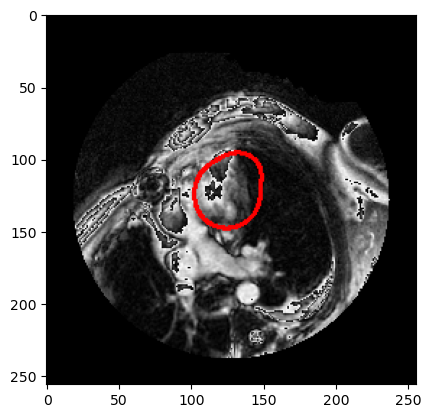

In [13]:
pos = 65
dicom = pydicom.dcmread(SCANS_PATH + relacao[pos].paciente_id + '/' + relacao[pos].scan)
dicom = np.array(dicom.pixel_array)
# plt.imshow(dicom)
# plt.show()


# #Converter imagem dicom para RGB
dicom_rgb = np.empty((256, 256, 3), dtype=dicom.dtype)
dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]

# # Desenhar o ground-truth na imagem
cv2.drawContours(dicom_rgb, np.array([relacao[pos].ground_truth]),  0, (255, 0, 0), 2)
plt.imshow(dicom_rgb.astype(np.uint8))
plt.show()

In [14]:
# Separar scans em potencial por contorno
all_values = [list[1] for list in relacao]
unique_values = set(all_values)

group_list = []
for value in unique_values:
  this_group = []
  for list in relacao:
    if list[1] == value:
      this_group.append(list[0])
  group_list.append(this_group)

In [15]:
group_list[0][-1]

'1.492_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSZGg7wAO5YccosEenixrkCVKPIdx8Vg6I_-y_-z_256_256_-72/CAP_SCD0001601_MR__hrt_raw_20120813121815917_167.dcm'

In [16]:
# Pegar o ultimo de cada scan com dimensao 256
temp = []
for i in range(len(group_list)):
    scan = group_list[i][-1]
    scan = scan.split("/")[0]
    temp.append(group_list[i][-1])

In [17]:
# Salvar possiveis combinacoes corretas
resultado = []
for scan in temp:
    match = re.search('\D{3}\d{7}', scan)
    match2 = re.search('\d{1,4}.dcm', scan)
    paciente = match.group(0)
    idnt = match2.group(0).split(".")[0]
    cnt = info_paciente[info_paciente['PatientID'] == paciente]
    cnt = cnt.values[0][1]
    
    resultado.append(CombFinal(scan, paciente, cnt, int(idnt)))


In [18]:
def resultado_contorno(res):
    for ct in contornos:
        if res.contorno_id == ct.contorno_id:
            if res.identificador == ct.identificador:
                return ct.arquivo

In [19]:
# Carregar imagens
imagens = []
for pos, _ in tqdm(enumerate(resultado), total=len(resultado)):
    dicom = pydicom.dcmread(SCANS_PATH + resultado[pos].paciente_id + '/' + resultado[pos].scan)
    dicom = np.array(dicom.pixel_array)
    # plt.imshow(dicom)
    # plt.show()
    
    
    # Converter imagem dicom para RGB
    dicom_rgb = np.empty((256, 256, 3), dtype=dicom.dtype)
    dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
    
    # Desenhar o ground-truth na imagem
    cv2.drawContours(dicom_rgb, np.array([resultado_contorno(resultado[pos])]),  0, (255, 0, 0), 2)
   
    imagens.append(dicom_rgb)

100%|██████████| 805/805 [00:18<00:00, 43.40it/s]


# Validação Visual

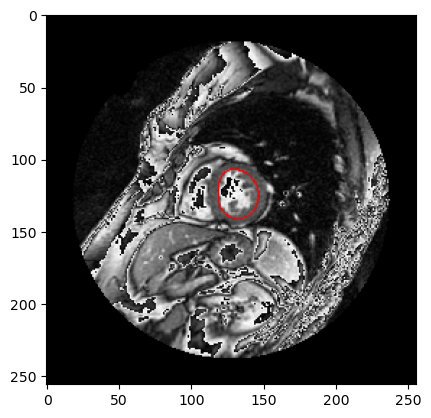

In [20]:
pos = 14
dicom = pydicom.dcmread(SCANS_PATH + resultado[pos].paciente_id + '/' + resultado[pos].scan)
dicom = np.array(dicom.pixel_array)
# plt.imshow(dicom)
# plt.show()


# Converter imagem dicom para RGB
dicom_rgb = np.empty((256, 256, 3), dtype=dicom.dtype)
dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]

# Pegar contorno

# Desenhar o ground-truth na imagem
cv2.drawContours(dicom_rgb, np.array([resultado_contorno(resultado[pos])]),  0, (255, 0, 0), 1)
plt.imshow(dicom_rgb.astype(np.uint8))
plt.show()

In [21]:
def mostrar_imagens(imgs, pos):
    rows = 4
    cols = 4
    axes=[]
    fig=plt.figure(figsize=(16, 16))
    cont = 0
    for a in range(pos, rows*cols + pos):
        axes.append(fig.add_subplot(rows, cols, cont+1))
        cont += 1
        subplot_title=("Subplot"+str(a))
        axes[-1].set_title(subplot_title)  
        plt.imshow(imgs[a].astype('uint8'))
    plt.show()

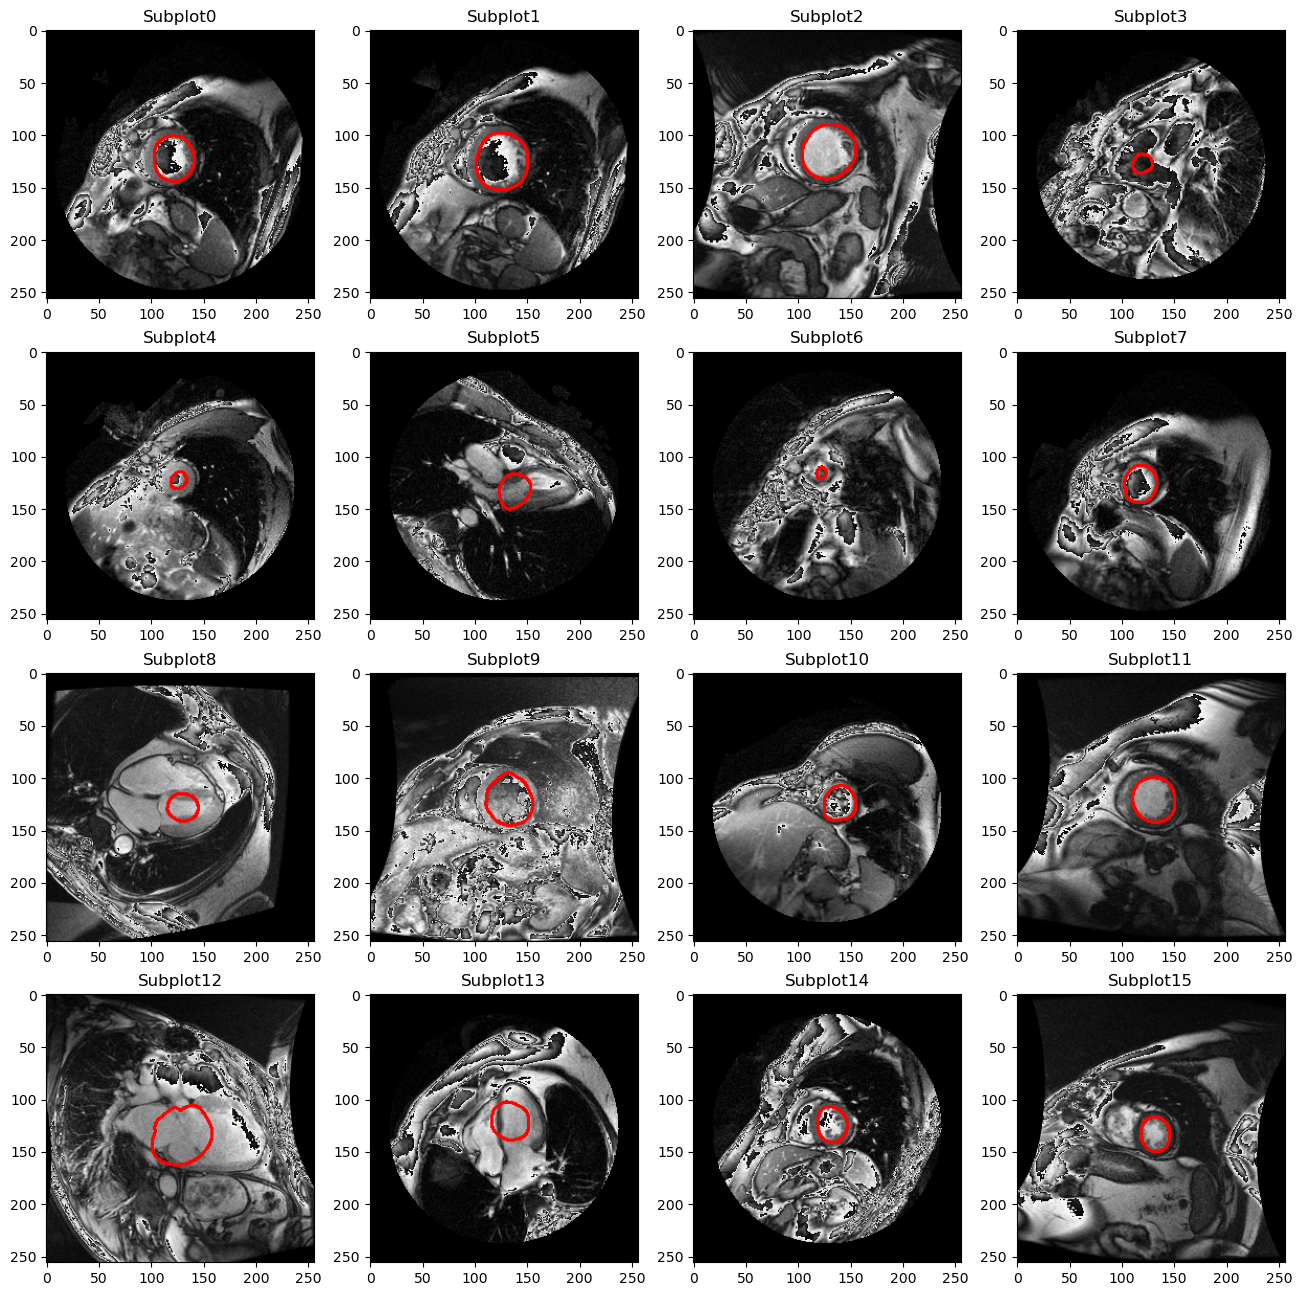

In [22]:
mostrar_imagens(imagens, 0)

# Testes de codigo

In [40]:
pos_img_273 = [2, 1, 2, 1, 3, 2, 1, 3, 2, 2, 1, 1, 1, 2, 6, 2, 2, 1, 2, 0, 1, 2, 3, 1, 0, 2, 3, 2, 2, 2, 2, 0, 6,
               0, 1, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 3, 1, 4, 3, 2, 5, 0, 2, 1, 3, 2, 2, 0, 0, 2,
               3, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 3, 1, 6, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0, 2, 1, 2,
               1, 1, 3, 2, 1, 0, 1, 1, 3, 2, 1, 2, 1, 1, 2, 0, 3, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 3, 2, 1,
               2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 3, 0, 1, 3, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 3, 2,
               1, 0, 2, 1, 2, 3, 1, 1, 2, 3, 3, 1, 0, 2, 3, 2, 0, 3, 1, 3, 0, 3, 8, 2, 0, 2, 2, 1, 3, 2, 3, 1, 2,
               2, 1, 1, 2, 2, 2, 3, 0, 1, 3, 2, 1, 2, 1, 3, 5, 2, 2, 0, 3, 1, 3, 0, 3, 1, 1, 4, 1, 2, 1, 2, 1, 2,
               1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 2, 3, 2, 2, 1, 1, 1, 2, 2, 1, 1, 0, 3, 0, 1, 2, 4, 1, 2, 2, 2, 1,
               1, 1, 2, 3, 1, 2, 2, 2, 1, 0, 3, 2, 3, 2, 2, 1, 1, 3, 0, 2, 1, 6, 1, 2, 1, 0, 2, 0, 0, 1, 1, 3, 1,
               1, 2, 2, 4, 4, 2, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 2, 1, 1, 0, 1, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
               0, 0, 2, 1, 1, 5, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 6, 1, 2, 2, 2, 2, 1, 1, 2, 2, 0, 1, 3, 1, 2, 2,
               2, 1, 0, 0, 2, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 3, 1, 1, 2, 3, 1, 1, 1, 2, 2, 2, 3, 1, 0, 2, 1,
               2, 1, 3, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 1, 2, 3, 2, 3, 2, 0, 0, 0, 0, 3, 3, 2, 1, 3, 2, 3, 1, 2, 3,
               3, 0, 2, 3, 1, 2, 1, 8, 3, 2, 2, 1, 1, 3, 3, 1, 0, 0, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 5,
               1, 2, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 1, 1, 2, 2, 1, 4, 1, 1, 0, 2, 2, 2, 1, 10, 2, 1, 4, 2, 2, 0,
               1, 1, 2, 3, 0, 0, 0, 3, 2, 1, 1, 1, 2, 0, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2]

final = []
selecionadas = []

In [41]:
len(pos_img_273)

531

In [25]:
group_list[39], temp[39]

(['1.16_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWS1BWoLdfeTvFDR4FmBN4CslKPIdx8Vg6I_-x_-z_256_256_85/CAP_SCD0002101_MR__hrt_raw_20120813122257643_140.dcm',
  '1.464_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWS1BWoLdfeTvFDR4FmBN4CslKPIdx8Vg6I_-x_-z_256_256_85/CAP_SCD0002101_MR__hrt_raw_20120813122244698_140.dcm'],
 '1.464_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWS1BWoLdfeTvFDR4FmBN4CslKPIdx8Vg6I_-x_-z_256_256_85/CAP_SCD0002101_MR__hrt_raw_20120813122244698_140.dcm')

In [26]:
def reavaliar_errados(pos):
    num = 0
    for i in group_list[pos]:
        dicom = pydicom.dcmread(SCANS_PATH + resultado[pos].paciente_id + '/' + i)
        dicom = np.array(dicom.pixel_array)
        
        # Converter imagem dicom para RGB
        dicom_rgb = np.empty((256, 256, 3), dtype=dicom.dtype)
        dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
        
        # Desenhar o ground-truth na imagem
        cv2.drawContours(dicom_rgb, np.array([resultado_contorno(resultado[pos])]),  0, (255, 0, 0), 1)
        plt.title("Pos " + str(num))
        num += 1
        plt.imshow(dicom_rgb.astype(np.uint8))
        plt.show()

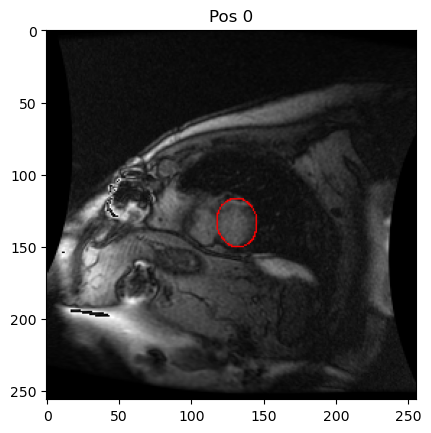

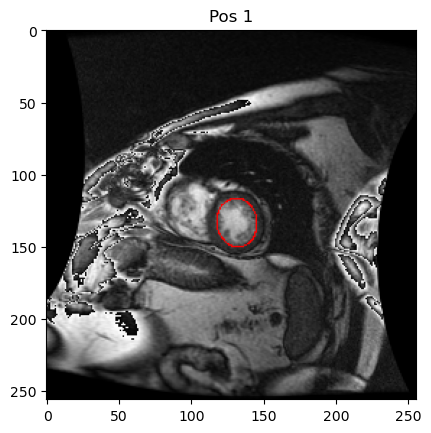

In [71]:
reavaliar_errados(seq)

In [72]:
add_imagem_certa(seq, 1)
seq += 1
print(seq)

16


In [35]:
resultado[804]

In [36]:
def add_imagem_certa(pos, pos_img):
    dicom = pydicom.dcmread(SCANS_PATH + resultado[pos].paciente_id + '/' + group_list[pos][pos_img])
#     dicom = np.array(dicom.pixel_array)    
    final.append(dicom)
    selecionadas.append(pos_img)

In [37]:
print(selecionadas)

[]


In [1868]:
# # Pegar todos os contornos
# for i in range(0, 805):
#     final_contorno.append(resultado_contorno(resultado[i]))
ler_arquivo_scans = open("scans_pickle.pickle", "rb")
f2 = pickle.load(ler_arquivo_scans)
ler_arquivo_scans.close()
f2

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

In [1870]:
import pickle

# SALVAR ARQUIVOS DOS SCANS E CONTORNOS
arquivo_scans = open("scans_pickle.pickle", "wb")
pickle.dump(final, arquivo_scans)

arquivo_scans.close()

arquivo_contorno = open("contorno_pickle.pickle", "wb")
pickle.dump(final_contorno, arquivo_contorno)
arquivo_contorno.close()



In [11]:
mascara_contorno = []

for ground_truth in final_contorno:
    mascara = np.zeros((256, 256, 3), dtype="uint8")
    cv2.drawContours(mascara, np.array([ground_truth]), 0, (255, 255, 255), cv2.FILLED)
    mascara_contorno.append(mascara)

In [13]:
import pickle

# SALVAR ARQUIVO DAS MASCARAS
arquivo_mascara = open("mascara_pickle.pickle", "wb")
pickle.dump(mascara_contorno, arquivo_mascara)
arquivo_mascara.close()

In [77]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image


# teste = transform_to_hu(final[0], final[0].pixel_array)


# plt.imshow(final[0].pixel_array)
# plt.show()

# plt.imshow(teste)
# plt.show()
final[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.7643801046090220799
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.8188283439478048534
(0002, 0013) Implementation Version Name         SH: 'OSIRIX'
(0002, 0016) Source Application Entity Title     AE: ''
-------------------------------------------------
(0008, 0000) Group Length                        UL: 676
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'CARDIAC', 'NONE']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UI

indice:  134
423
